In [25]:
%matplotlib inline
from pyvi import ViTokenizer, ViPosTagger
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import re
from langdetect import detect
from sklearn.tree import DecisionTreeClassifier
from gensim.parsing.preprocessing import strip_non_alphanum, strip_multiple_whitespaces,preprocess_string, split_alphanum, strip_short, strip_numeric

In [6]:
class FeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, *_):
        return self

    def transform(self, X, y=None, **fit_params):
        result = [ViTokenizer.tokenize(text) for text in X]
        return result

In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier, LogisticRegression

class NaiveBayesModel(object):
    def __init__(self):
        self.clf = self._init_pipeline()

    @staticmethod
    def _init_pipeline():
        pipe_line = Pipeline([
            ("transformer", FeatureTransformer()),#sử dụng pyvi tiến hành word segmentation
            ("vect", CountVectorizer()),#bag-of-words
            ("tfidf", TfidfTransformer()),#tf-idf
            ("clf", MultinomialNB())#model naive bayes
        ])

        return pipe_line
    
class SVMModel(object):
    def __init__(self):
        self.clf = self._init_pipeline()

    @staticmethod
    def _init_pipeline():
        pipe_line = Pipeline([
            ("transformer", FeatureTransformer()),
            ("vect", CountVectorizer()),
            ("tfidf", TfidfTransformer()),
            ("clf-svm", SGDClassifier(loss='log', penalty='l2', alpha=1e-3, random_state=None))
        ])

        return pipe_line
    
class LRModel(object):
    def __init__(self):
        self.clf = self._init_pipeline()

    @staticmethod
    def _init_pipeline():
        pipe_line = Pipeline([
#             ("transformer", FeatureTransformer()),
            ("vect", CountVectorizer()),
            ("tfidf", TfidfTransformer()),
            ("clf-svm", LogisticRegression())
        ])

        return pipe_line

In [81]:
print(sum(train_acc) / len(train_acc), sum(test_acc) / len(test_acc))

0.9434636067560402 0.8574445931875652


In [27]:
y[:-80].sum()

161

In [16]:
stop_words = []
en_stop_words = []
with open("vietnamese-stopwords.txt", "r") as f:
    for line in f:
        stop_words.append(line.strip())
        
with open("english-stopwords.txt", "r") as f:
    for line in f:
        en_stop_words.append(line.strip())

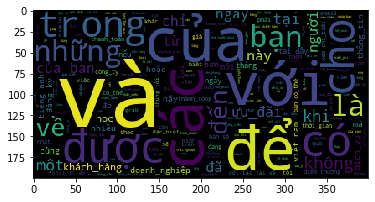

In [170]:
spam_arr = ' '.join([text for text, label in zip(X,y) if label==0])
spam_wc = WordCloud().generate(spam_arr)
plt.imshow(spam_wc)

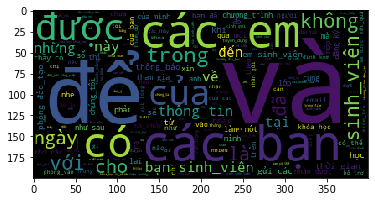

In [172]:
nonspam_arr = ' '.join([text for text, label in zip(X,y) if label==1])
nonspam_wc = WordCloud().generate(nonspam_arr)
plt.imshow(nonspam_wc)

## SEPARATE STEPS

In [11]:
data, X, y = load_data("data_email.txt", remove_en=False)

In [12]:
def tokenize(X):
    return [ViTokenizer.tokenize(text) for text in X]

In [14]:
X = tokenize(X)
X_train, y_train, X_test, y_test = X[:-80], y[:-80], X[-80:], y[-80:]

In [17]:
cv=CountVectorizer()
word_count_vector=cv.fit_transform(X_train)

In [18]:
word_count_vector.shape

(327, 5353)

In [14]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
X_train_tfidf = tfidf_transformer.fit_transform(word_count_vector)

In [15]:
idx = np.argsort(X_train_tfidf.toarray().sum(axis=0))

In [16]:
cv.vocabulary_['sinh_viên']

2443

In [17]:
d_spam = {}
spam_index = []
for spam_i in range(len(y_train)):
    if y_train[spam_i] == 0:
        spam_index.append(spam_i)
    
for i in range(word_count_vector.shape[1]):
    
    d_spam[cv.get_feature_names()[i]] = np.sum(word_count_vector[spam_index,i])

In [18]:
d_non_spam = {}
non_spam_index = []
for non_spam_i in range(len(y_train)):
    if y_train[non_spam_i] == 1:
        non_spam_index.append(non_spam_i)
    
for i in range(word_count_vector.shape[1]):
    
    d_non_spam[cv.get_feature_names()[i]] = np.sum(word_count_vector[non_spam_index,i])

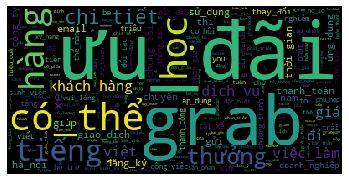

In [21]:
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d_spam)
plt.axis("off")
plt.imshow(wordcloud)

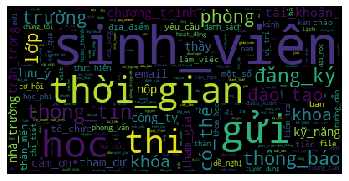

In [22]:
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d_non_spam)
plt.axis("off")
plt.imshow(wordcloud)

In [366]:
for i in range(1,20):
    print(cv.get_feature_names()[idx[-i]])

sinh_viên
học
gửi
ưu_đãi
thi
đăng_ký
có_thể
grab
thời_gian
thông_báo
thông_tin
tài_khoản
thưởng
lớp
công_ty
phòng
khoa
chương_trình
hàng


In [146]:
clf = LogisticRegression().fit(X_train_tfidf, y_train)

/home/mxw/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [147]:
X_test_count = cv.transform(X_test)
X_test_tfidt = tfidf_transformer.transform(X_test_count)

In [148]:
pred = clf.predict(X_test_tfidt)

In [149]:
accuracy_score(pred, y_test)

0.9

In [213]:
text_clf = Pipeline([
        ("transformer", FeatureTransformer()),
        ('vect', CountVectorizer(stop_words=stop_words + en_stop_words)),
        ('tfidf', TfidfTransformer(smooth_idf=True,use_idf=True)),
        ('clf', LogisticRegression()),
    ])

In [214]:
text_clf.fit(X_train, y_train)
pred = text_clf.predict(X_test)

/home/mxw/.local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'bao', 'bay', 'biến', 'biệt', 'bây', 'bõm', 'bảo', 'bất', 'bẩy', 'bập', 'bắt', 'bội', 'can', 'chao', 'chi', 'chia', 'chu', 'chui', 'chuẩn', 'chà', 'chành', 'chí', 'chót', 'chùn', 'chăn', 'chũn', 'chưng', 'chạnh', 'chả', 'chầm', 'chầy', 'chập', 'chắn', 'chẳng', 'chết', 'chốc', 'chừ', 'chừng', 'coi', 'couldn', 'cu', 'cá', 'câu', 'cóc', 'công', 'cạnh', 'cảm', 'cầu', 'cật', 'cắt', 'cổ', 'cụ', 'cục', 'cực', 'da', 'didn', 'doesn', 'don', 'dà', 'dĩ', 'dưng', 'dần', 'dầu', 'dịp', 'dở', 'dụng', 'gian', 'giá', 'giác', 'giời', 'ha', 'hadn', 'hasn', 'haven', 'hiện', 'hoàn', 'hèn', 'hình', 'hô', 'hầu', 'hậu', 'hẳn', 'hồ', 'hỗ', 'hội', 'hợp', 'hự', 'isn', 'khói', 'khô', 'khăn', 'khắc', 'khẳng', 'kia', 'kiện', 'kê', 'kì', 'kìa', 'kỳ', 'lai', 'le', 'let', 'liên', 'liệt', 'll', 'loạt', 'luận', '

In [215]:
accuracy_score(pred, y_test)

0.925

### ___________
# Final Code

In [9]:
def load_data(path, remove_en=False):
    data = []
    X = []
    y = []
    with open(path, "r") as lines:
        for line in lines:
            if remove_en:
                if detect(line) == "en":
                    continue
                    
            index = line.find("|")
            
            text = line[index+1:].strip().lower()
            text = raw_text_preprocess(text)
            label = line[:index].strip()

            data.append({"feature": text, "target": label})
            X.append(text)
            if label == "spam":
                y.append(0)
            else:
                y.append(1)
            
    shuffle = np.array(range(len(X)))
    np.random.shuffle(shuffle)
    X = np.array(X)
    y = np.array(y)
    return data, X[shuffle], y[shuffle]

In [10]:
def raw_text_preprocess(raw):
    raw = re.sub(r"(http:\/\/www\.|https:\/\/www\.|http:\/\/|https:\/\/)?[a-z0-9]+([\-\.]{1}[a-z0-9]+)*\.[a-z]{2,5}(:[0-9]{1,5})?(\/.*)?", "", raw)
#     raw = re.sub(r"[a-zA-Z0-9.!#$%&'*+/=?^_`{|}~-]+@[a-zA-Z0-9](?:[a-zA-Z0-9-]{0,61}[a-zA-Z0-9])?(?:\.[a-zA-Z0-9](?:[a-zA-Z0-9-]{0,61}[a-zA-Z0-9])?)*", "", raw)
#     raw = strip_non_alphanum(raw).lower().strip()
#     raw = ViTokenizer.tokenize(raw)
#     raw = split_alphanum(raw)
#     raw = strip_short(raw, minsize=2)
    raw = strip_numeric(raw)
    
    return raw

In [21]:
data, X, y = load_data("data_email.txt", remove_en=False)

In [34]:
train_acc = {}
test_acc = {}

models = [
    SGDClassifier(loss='hinge', epsilon=0.5, max_iter=10000, tol=1e-5, alpha=1e-2), # SVM
    SGDClassifier(loss='log', epsilon=0.5, max_iter=10000, tol=1e-5, alpha=1e-2), # Logistic Regression
    DecisionTreeClassifier(), 
    MultinomialNB()
]

names = [
    "SVM",
    "LR",
    "DTree",
    "NBayes"
]

skf = StratifiedKFold(n_splits=5)
i = 0
for train_index, test_index in skf.split(X, y):
    X_train, y_train, X_test, y_test = X[train_index], y[train_index], X[test_index], y[test_index]
    for model_name, model in zip(names, models):
#         model_name = type(model).__name__
        if model_name not in train_acc:
            train_acc[model_name] = []
            
        if model_name not in test_acc:
            test_acc[model_name] = []
            
        
        text_clf = Pipeline([

            ("transformer", FeatureTransformer()),
            ('vect', CountVectorizer()),
            ('tfidf', TfidfTransformer()),
    #         ('clf', SGDClassifier(penalty='l2', loss='hinge', epsilon=0.5, max_iter=10000, tol=1e-5, alpha=1e-2)),
            ('clf', model)

        ])
        print(model_name, "fold " + str(i))
        text_clf.fit(X_train, y_train)
    #     break
        predicted = text_clf.predict(X_test)
        k_test_acc = accuracy_score(predicted, y_test)
#         test_acc.append(k_test_acc)

        predicted2 = text_clf.predict(X_train)
        k_train_acc = accuracy_score(predicted2, y_train)
#         train_acc.append(k_train_acc)
        
        train_acc[model_name].append(k_train_acc)
        test_acc[model_name].append(k_test_acc)
        
    i += 1
#         print(k_train_acc, k_test_acc)
#         print(len(X_train), len(X_test))
        
# print(np.array(train_acc).mean())
# print(np.array(test_acc).mean())

SVM fold 0
LR fold 0
DTree fold 0
NBayes fold 0
SVM fold 1
LR fold 1
DTree fold 1
NBayes fold 1
SVM fold 2
LR fold 2
DTree fold 2
NBayes fold 2
SVM fold 3
LR fold 3
DTree fold 3
NBayes fold 3
SVM fold 4
LR fold 4
DTree fold 4
NBayes fold 4


In [35]:
train_acc

{'SVM': [0.8981481481481481,
  0.9049079754601227,
  0.8957055214723927,
  0.8987730061349694,
  0.8895705521472392],
 'LR': [0.9074074074074074,
  0.9141104294478528,
  0.9202453987730062,
  0.9141104294478528,
  0.9141104294478528],
 'DTree': [0.9938271604938271,
  0.9938650306748467,
  0.99079754601227,
  0.9877300613496932,
  0.99079754601227],
 'NBayes': [0.941358024691358,
  0.9539877300613497,
  0.9355828220858896,
  0.950920245398773,
  0.9386503067484663]}

In [36]:
test_acc

{'SVM': [0.891566265060241,
  0.8518518518518519,
  0.8271604938271605,
  0.8518518518518519,
  0.8641975308641975],
 'LR': [0.9036144578313253,
  0.8518518518518519,
  0.8148148148148148,
  0.8395061728395061,
  0.8765432098765432],
 'DTree': [0.7349397590361446,
  0.8024691358024691,
  0.6790123456790124,
  0.8148148148148148,
  0.8518518518518519],
 'NBayes': [0.8674698795180723,
  0.8518518518518519,
  0.7901234567901234,
  0.8641975308641975,
  0.8395061728395061]}

# ...

In [73]:
def sigmoid(s):
    return 1/(1 + np.exp(-s))

def logistic_sigmoid_regression(X, y, w_init, eta, tol = 1e-4, max_count = 10000):
    w = [w_init]    
    it = 0
    N = X.shape[1]
    d = X.shape[0]
    count = 0
    check_w_after = 20
    while count < max_count:
        # mix data 
        mix_id = np.random.permutation(N)
        for i in mix_id:
            xi = X[:, i].reshape(d, 1)
            yi = y[i]
            zi = sigmoid(np.dot(w[-1].T, xi))
            w_new = w[-1] + eta*(yi - zi)*xi
            count += 1
            # stopping criteria
            if count%check_w_after == 0:                
                if np.linalg.norm(w_new - w[-check_w_after]) < tol:
                    return w
            w.append(w_new)
    return w
eta = 1e-2
d = X_train_tfidf.toarray().T.shape[0]
w_init = np.random.randn(d, 1)

w = logistic_sigmoid_regression(X_train_tfidf.toarray().T, y_train, w_init, eta)
print(w[-1])

[[ 0.15047604]
 [ 0.4701215 ]
 [ 0.77865378]
 ...
 [-0.13847709]
 [ 0.80471196]
 [-1.67209359]]


In [74]:
pred = sigmoid(np.dot(w[-1].T, X_test_tfidt.toarray().T))

In [75]:
pred[pred >= 0.5] = 1
pred[pred < 0.5] = 0

In [76]:
accuracy_score(pred[0,:], y_test)

0.55